In [239]:
# Import packages.
import numpy as np
import matplotlib.pyplot as plt
import qctrlvisualizer
import boulderopal as bo
import qutip as qt
import sys, os
sys.path.append('/Users/sebastien/Documents/Code/QRAM/qutip_sims')
from QSwitch import QSwitch
import time
import scipy as sp
from PulseSequence import PulseSequence
from tqdm import tqdm

import matplotlib as mpl
mpl.style.use('default')

# Apply Q-CTRL style to plots created in pyplot.
# plt.style.use(qctrlvisualizer.get_qctrl_style())

# Start a Boulder Opal session.

%matplotlib widget
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# General definitions

## Define the  parameters

In [282]:

# Pulse parameters
segment_count = 100
gate_duration = 100*1e-9  # s

# check that the gate duration is a multiple of the segment count

dt = np.round(gate_duration*1e9 / segment_count,3)
gate_duration = dt*segment_count*1e-9
print(f'Actual gate duration: {gate_duration} s')



# cutoff_freq = 1e9 # Hz
cutoff_freq = 500e6 # Hz
# Maximum value for |α(t)|.
drive_max = 2*np.pi*50*1e6/10 # rad/s
penalty_coeff = 1e-2
penalty_segments = segment_count
twoQ = False
qubit_drive_idx = [0, 1]

Actual gate duration: 1.0000000000000001e-07 s


In [293]:
if twoQ:
    f_ef =  np.array([4140.533743739655, 3463.728373773443])*1e6 # [MHz]
    qubit_freqs = np.array([3914.7570214638718, 3363.398427976613])*1e6
    alphas = (f_ef - qubit_freqs)
    g =  54.38663964*1e6
    gs = np.zeros((2,2))
    gs[0, 1] = g
    gs[1, 0] = g

    # cutoffs= [3, 4]
    cutoffs= [3, 3]

else:
    qubit_freqs = np.array([4140.533743739655, 3463.728373773443, 4800.1199711068375, 4415.307783242773])*1e6
    ef_freqs = np.array([3914.7570214638718, 3363.398427976613, 4610.7977211230145, 4243.1626645869358])*1e6
    alphas = ef_freqs - qubit_freqs

    gs = np.zeros((4,4))
    gs[0, 1] = 54.38663964*1e6
    gs[1, 2] = 52.60236201*1e6
    gs[1, 3] = 41.1249601*1e6
    gs[0, 2] = 6.26475719*1e6
    gs[0, 3] = 2.73059709*1e6
    gs[2, 3] = 6.00700312*1e6

    gs = gs + gs.T


    cutoffs= [3, 3, 3, 3]

avoided_state = [None, None, None, None]




In [294]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
def show_mat_2d(mat, ax, title, labels, cmax=1, show=True):
    """
    Plot an arbitrary 2D matrix with labels
    """
    plt.sca(ax)
    plt.title(title)
    plt.imshow(np.real(mat), cmap='RdBu')
    # hinton(np.real(mat), xlabels=labels, ylabels=labels)
    plt.xticks(np.arange(len(mat)), labels,rotation='vertical',verticalalignment='top')
    plt.yticks(np.arange(len(mat)), labels)
    # Loop over data dimensions and create text annotations.
    for ii in range(len(mat)):
        for jj in range(len(mat)):
            plt.text(ii, jj, round(mat[jj, ii], 2), ha="center", va="center", color="w", size=11)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(cax=cax)
    plt.clim(vmin=-cmax, vmax=cmax)
    plt.tight_layout()
    if show: plt.show()

def show_plot_rho_2d(rho_test, rho_id=None, title='', cmax=None, savetitle=None, figsize=(15, 15)):
    """
    Plot real and imag parts of rho, optionally also with a comparison ideal rho
    """
    if savetitle is not None: plt.style.use('dark_background')

    cutoffs = rho_test.dims[0]
    print(len(cutoffs))

    if len(cutoffs) == 4:
        labels = [f'$|{qram.level_nums_to_name([i, j, k, l])}\\rangle$' for i in range(2) for j in range(2) for k in range(2) for l in range(2)]
    elif len(cutoffs) == 3:
        labels = [f'$|{qram.level_nums_to_name([i, j, k])}\\rangle$' for i in range(2) for j in range(2) for k in range(2)]
    elif len(cutoffs) == 2:
        labels = [f'$|{qram.level_nums_to_name([i, j])}\\rangle$' for i in range(2) for j in range(2)]
    else:
        labels = [f'$|{qram.level_nums_to_name([i])}\\rangle$' for i in range(2)]
    fig, ax = plt.subplots(2, 1, figsize=figsize)


    plt.suptitle(title, fontsize=18)
    if cmax is None: cmax = np.max(np.abs(np.array([np.real(rho_test), np.imag(rho_test), np.real(rho_id), np.imag(rho_id)])))
    show_mat_2d(np.real(rho_test), ax=ax[0], title="Re[$\\rho_{MLE}$]", labels=labels, cmax=cmax, show=False)
    show_mat_2d(np.imag(rho_test), ax=ax[1], title="Im[$\\rho_{MLE}$]", labels=labels, cmax=cmax, show=False)
    plt.tight_layout()

    if savetitle is not None:
        plt.savefig(savetitle, format='png', bbox_inches='tight', transparent = True)
    
    plt.show()

 ## Define Hamiltonians

In [295]:
isCavity = [False, False, False, False]

qram = QSwitch(
    EJs=None,
    ECs=None,
    gs=gs,
    qubit_freqs=qubit_freqs,
    alphas=alphas,
    cutoffs=cutoffs,
    isCavity=isCavity,
    useZZs=False,
    ZZs=None,
)

print('qubit freqs (GHz)', qram.qubit_freqs/1e9)
print('alphas (GHz)', qram.alphas/1e9)

# define the dressed parameters  
freq_dressed = qram.get_dressed_frequencies()
self_kerr = qram.get_self_kerr()/2/np.pi
ZZ_mat = qram.get_ZZ_matrix()
M = np.diag(qubit_freqs) + gs 
# find the eigenvalues and eigenvectors 
eigenvalues, eigenvectors = np.linalg.eigh(M)
# sort the eigenvalues to match dressed frequency 
idx = np.array([np.argmin(np.abs(eigenvalues  - freq_dressed[k]/2/np.pi)) for k in range(len(freq_dressed))])
eigenvectors = np.abs(eigenvectors[:, idx])


qram_zz_rot = QSwitch(
    EJs=None,
    ECs=None,
    gs=None,
    qubit_freqs=freq_dressed*0,
    alphas=self_kerr,
    cutoffs=cutoffs,
    isCavity=isCavity,
    useZZs=True,
    ZZs=ZZ_mat,
    crosstalk=None,
)


H_zz_rot = qram_zz_rot.H
# H_zz_rot = qram.H
graph = bo.Graph()


# H_drift = graph.pwc_operator(
#     signal=graph.pwc_signal(values=np.array([1]), duration=gate_duration),
#     operator=H_zz_rot.data.todense(),
# )

H_drift = graph.constant_pwc(constant=H_zz_rot.data.todense(), duration=gate_duration)

Crosstalk 0 0 1.0
Crosstalk 0 1 0.0
Crosstalk 0 2 0.0
Crosstalk 0 3 0.0
Crosstalk 1 1 1.0
Crosstalk 1 0 0.0
Crosstalk 1 2 0.0
Crosstalk 1 3 0.0
Crosstalk 2 2 1.0
Crosstalk 2 0 0.0
Crosstalk 2 1 0.0
Crosstalk 2 3 0.0
Crosstalk 3 3 1.0
Crosstalk 3 0 0.0
Crosstalk 3 1 0.0
Crosstalk 3 2 0.0
qubit freqs (GHz) [4.14053374 3.46372837 4.80011997 4.41530778]
alphas (GHz) [-0.22577672 -0.10032995 -0.18932225 -0.17214512]
1
One photon transition
1
One photon transition
1
One photon transition
1
One photon transition
1
One photon transition
1
One photon transition
1
One photon transition
1
One photon transition
1
One photon transition
1
One photon transition
1
One photon transition
1
One photon transition
1
One photon transition
1
One photon transition
1
One photon transition
1
One photon transition
1
One photon transition
1
One photon transition
1
One photon transition
1
One photon transition
1
One photon transition
1
One photon transition
1
One photon transition
1
One photon transition
Crosstalk

### Add the drive

In [296]:
def graph_hamiltonian(qram, params, **kwargs):

    nb_qubits = qram.nb_qubits
    cutoffs = qram.cutoffs
    gate_duration = params['gate_duration']
    segment_count = params['segment_count']
    drive_max = params['drive_max']
    cutoff_freq = params['cutoff_freq']
    driven_qubits = params['driven_qubits']

    graph = bo.Graph()
    H_drift = graph.constant_pwc(constant=qram.H.data.todense(), duration=gate_duration)

    envelope_signal = graph.signals.cosine_pulse_pwc(duration=gate_duration, segment_count=segment_count, amplitude=1.0)
    drives = []

    for i in driven_qubits:


        I_raw = graph.real_optimizable_pwc_signal(segment_count=segment_count, duration=gate_duration, maximum=drive_max,minimum=-drive_max, name=f'I_raw_{i}')
        Q_raw = graph.real_optimizable_pwc_signal(segment_count=segment_count, duration=gate_duration, maximum=drive_max, minimum=-drive_max, name=f'Q_raw_{i}')

        I_filtered = graph.filter_and_resample_pwc(
            pwc=I_raw,
            kernel= graph.sinc_convolution_kernel(cutoff_freq),
            segment_count=segment_count,
            name=f"I_filtered_{i}",
        )

        Q_filtered = graph.filter_and_resample_pwc(
            pwc=Q_raw,
            kernel= graph.sinc_convolution_kernel(cutoff_freq),
            segment_count=segment_count,
            name=f"Q_filtered_{i}",
        )

        I = I_filtered * envelope_signal
        Q = Q_filtered * envelope_signal

        I.name = f'I_{i}'
        Q.name = f'Q_{i}'

        drives.append(graph.hermitian_part(graph.pwc_operator(signal=(I - 1j*Q) * 2 * np.pi, operator=qram_zz_rot.a_ops[i].data.todense())))

    H_drive = graph.pwc_sum(drives)
    H_tot = graph.pwc_sum([H_drift, H_drive])



I1_raw = graph.real_optimizable_pwc_signal(segment_count=segment_count, duration=gate_duration, maximum=drive_max,minimum=-drive_max, name='I1_raw')
Q1_raw = graph.real_optimizable_pwc_signal(segment_count=segment_count, duration=gate_duration, maximum=drive_max, minimum=-drive_max, name='Q1_raw')
I2_raw = graph.real_optimizable_pwc_signal(segment_count=segment_count, duration=gate_duration, maximum=drive_max,minimum=-drive_max, name='I2_raw')
Q2_raw = graph.real_optimizable_pwc_signal(segment_count=segment_count, duration=gate_duration, maximum=drive_max, minimum=-drive_max, name='Q2_raw')

I1_filtered = graph.filter_and_resample_pwc(
    pwc=I1_raw,
    kernel= graph.sinc_convolution_kernel(cutoff_freq),
    segment_count=segment_count,
    name="I1_filtered",
)

Q1_filtered = graph.filter_and_resample_pwc(
    pwc=Q1_raw,
    kernel= graph.sinc_convolution_kernel(cutoff_freq),
    segment_count=segment_count,
    name="Q1_filtered",
)

I2_filtered = graph.filter_and_resample_pwc(
    pwc=I2_raw,
    kernel= graph.sinc_convolution_kernel(cutoff_freq),
    segment_count=segment_count,
    name="I2_filtered",
)

Q2_filtered = graph.filter_and_resample_pwc(
    pwc=Q2_raw,
    kernel= graph.sinc_convolution_kernel(cutoff_freq),
    segment_count=segment_count,
    name="Q2_filtered",
)


# Modulate signal with envelope.
envelope_signal = graph.signals.cosine_pulse_pwc(duration=gate_duration, segment_count=segment_count, amplitude=1.0)


I1 = I1_filtered * envelope_signal
Q1 = Q1_filtered * envelope_signal
I2 = I2_filtered * envelope_signal
Q2 = Q2_filtered * envelope_signal

I1.name = 'I1'
Q1.name = 'Q1'
I2.name = 'I2'
Q2.name = 'Q2'

##########


drives = []
drives.append(graph.hermitian_part(graph.pwc_operator(signal=(I1 - 1j*Q1) * 2 * np.pi, operator=qram_zz_rot.a_ops[0].data.todense())))
drives.append(graph.hermitian_part(graph.pwc_operator(signal=(I2 - 1j*Q2) * 2 * np.pi, operator=qram_zz_rot.a_ops[1].data.todense())))

H_drive = graph.pwc_sum(drives)
H_tot = graph.pwc_sum([H_drift, H_drive])

### Ideal operation

In [297]:
def transform_ideal_to_fock_frame(U_ideal, H_to, gate_duration=0):
    evals, evecs = H_to.eigenstates()
    evals_ordered = []
    evecs_ordered = []
    # print('evecs', evecs)
    # Loop over fock basis to order the dressed evecs
    matrix_size = np.prod(cutoffs)
    for i in range(matrix_size):
        evec_fock = np.zeros(matrix_size)
        evec_fock[i] = 1
        evec_fock = qt.Qobj(evec_fock, dims=evecs[0].dims)
        best_state, best_overlap, best_evec = qram.find_dressed(evec_fock, esys=(evals, evecs))
        # print(best_state)
        evals_ordered.append(evals[best_state])
        evecs_ordered.append(best_evec)
        # print('evals_ordered', evals_ordered)
        # print('evecs_ordered', evecs_ordered)
        # print('evec_fock', evec_fock)

    R_dressed_to_fock = np.array([evec.unit().full().flatten() for evec in evecs_ordered]).T
    # H_to_ordered = R_dressed_to_fock @ np.diag(evals_ordered) @ R_dressed_to_fock.conjugate().T
    # # H_to_ordered = np.diag(evals_ordered) 
    # # print('H_to_ordered', H_to_ordered)

    # # TAKE THE IDEAL OPERATOR FROM RF OF ALL QUBITS -> FRAME OF SIMS (i.e. produce the phase accumulation that would be accumulated in the sims when solving in H_to)
    # # Time evolution should only be applied to one side of the U_target bc the goal is to evolve the state that U_target is applied to not U_target itself
    # R_rf_to_lab = sp.linalg.expm(-1j*H_to_ordered*gate_duration)

    # U_target = R_rf_to_lab @ R_dressed_to_fock @ U_ideal @ R_dressed_to_fock.conjugate().T
    U_target = R_dressed_to_fock @ U_ideal @ R_dressed_to_fock.conjugate().T
    # U_target = R_rf_to_lab @ U_ideal

    return U_target


# def subspace_proj(U, twoQ):

#     if twoQ:
#         n_qbs = 2
#     else:
#         n_qbs = 4

#     projected_basis = []
#     qubit_states = [None]*n_qbs
#     for q in range(n_qbs):
#         gstate = qt.basis(cutoffs[q], 0)
#         estate = qt.basis(cutoffs[q], 1)
#         qubit_states[q] = [gstate, estate]

#     for q in [0,1,2,3]:
#         tensor_state = [qt.basis(cutoffs[q], 0) for q in range(n_qbs)] # gggg
#         # print('tensor_state', tensor_state)
#         if q != 1:
#             tensor_state[q] = qubit_states[q][1] # estate
#             # print('tensor_state', tensor_state)
#         for q1_state in qubit_states[1]:
#             tensor_state[1] = q1_state
#             # print('tensor_state', tensor_state)
#             projected_basis.append(qt.tensor(*tensor_state))
#             # print('projected_basis', projected_basis)
#     computational_projector = np.zeros(shape=(np.prod(cutoffs), np.prod(cutoffs)), dtype=np.complex128)
#     # print('projected_basis', projected_basis)
#     for state in projected_basis:
#         computational_projector += (state * state.dag()).full()

#     # print('computational_projector', computational_projector)

#     qobj = qt.Qobj(computational_projector)
#     print(qobj)

#     return computational_projector.conjugate().T @ U @ computational_projector


def subspace_proj(U, twoQ):

    if twoQ:
        n_qbs = 2
    else:
        n_qbs = 4

    projected_basis = []
    qubit_states = [None]*n_qbs
    for q in range(n_qbs):
        gstate = qt.basis(cutoffs[q], 0)
        estate = qt.basis(cutoffs[q], 1)
        qubit_states[q] = [gstate, estate]

    if twoQ:
        for q1 in qubit_states[0]:
            for q2 in qubit_states[1]:
                tensor_state = [q1, q2]
                projected_basis.append(qt.tensor(*tensor_state))
    else:
        for q1 in qubit_states[0]:
            for q2 in qubit_states[1]:
                for q3 in qubit_states[2]:
                    for q4 in qubit_states[3]:
                        tensor_state = [q1, q2, q3, q4]
                        projected_basis.append(qt.tensor(*tensor_state))

    computational_projector = np.zeros(shape=(np.prod(cutoffs), np.prod(cutoffs)), dtype=np.complex128)

    for state in projected_basis:
        computational_projector += (state * state.dag()).full()

    print('computational_projector', qt.Qobj(computational_projector))
    
    return computational_projector.conjugate().T @ U @ computational_projector


def subspace_penalty(twoQ, avoided_state):

    if twoQ:
        n_qbs = 2
    else:
        n_qbs = 4

    projected_basis = []
    qubit_states = [None]*n_qbs
    
    for q in range(n_qbs):
        state_range = np.arange(cutoffs[q])
        if avoided_state[q] is not None:
            print('avoided_state', avoided_state[q])
            state_range = np.delete(state_range, np.array(avoided_state[q]) - 1)
        qubit_states[q] = [qt.basis(cutoffs[q], state) for state in state_range]


    if twoQ:
        for q1 in qubit_states[0]:
            for q2 in qubit_states[1]:
                tensor_state = [q1, q2]
                projected_basis.append(qt.tensor(*tensor_state))
    else:
        for q1 in qubit_states[0]:
            for q2 in qubit_states[1]:
                for q3 in qubit_states[2]:
                    for q4 in qubit_states[3]:
                        tensor_state = [q1, q2, q3, q4]
                        projected_basis.append(qt.tensor(*tensor_state))

    computational_projector_temp = np.zeros(shape=(np.prod(cutoffs), np.prod(cutoffs)), dtype=np.complex128)
    identity = np.eye(np.prod(cutoffs), dtype=np.complex128)

    for state in projected_basis:
        computational_projector_temp += (state * state.dag()).full()

    computational_projector = identity - computational_projector_temp

    print('computational_projector', qt.Qobj(computational_projector))

    # return computational_projector.conjugate().T @ U @ computational_projector
    return computational_projector



In [298]:
Xfull = np.eye(cutoffs[1], dtype=complex)
X = qt.qip.operations.rx(np.pi/2)
X = np.array(X)
# Xfull[:2, :2] = np.array([[0, 1], [1, 0]])
Xfull[:2, :2] = X
Xfull = qt.Qobj(Xfull, dims=[[cutoffs[1]], [cutoffs[1]]])
# Id = qt.qeye(cutoffs[1])

# # X_full = qt.tensor(Xfull, qt.qeye(cutoffs[1]))
# X_full = qt.tensor(qt.qeye(cutoffs[0]), Xfull)


# eg_ge swap 

# eg = qt.tensor([qt.basis(cutoffs[0], 1), qt.basis(cutoffs[1], 0)])
# ge = qt.tensor([qt.basis(cutoffs[0], 0), qt.basis(cutoffs[1], 1)])

# SWAP = np.eye(cutoffs[0]*cutoffs[1], dtype='complex128')

# SWAP -= (eg * eg.dag()).full()
# SWAP -= (ge * ge.dag()).full()
# SWAP += (eg * ge.dag()).full()
# SWAP += (ge * eg.dag()).full()


# SWAP = qt.Qobj(SWAP, dims=[[cutoffs[0], cutoffs[1]], [cutoffs[0], cutoffs[1]]])


if twoQ:
    U_ideal = qt.tensor([qt.qeye(cutoffs[0]),Xfull]).full()
    # U_ideal = SWAP.full()
else:
    U_ideal = qt.tensor([qt.qeye(cutoffs[0]),Xfull, qt.qeye(cutoffs[2]),qt.qeye(cutoffs[3])]).full()
    # U_ideal = qt.tensor([qt.qeye(cutoffs[0]),SWAP, qt.qeye(cutoffs[3])]).full()
    # U_ideal = qt.tensor([SWAP,qt.qeye(cutoffs[2]), qt.qeye(cutoffs[3])]).full()




U_penalty = subspace_penalty(twoQ, avoided_state)
U_dressed = transform_ideal_to_fock_frame(U_ideal, qram_zz_rot.H, gate_duration=gate_duration)
U_target = subspace_proj(U_dressed,twoQ)

computational_projector Quantum object: dims = [[81], [81]], shape = (81, 81), type = oper, isherm = True
Qobj data =
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
computational_projector Quantum object: dims = [[81], [81]], shape = (81, 81), type = oper, isherm = True
Qobj data =
[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [299]:
qt.Qobj(U_target)

Quantum object: dims = [[81], [81]], shape = (81, 81), type = oper, isherm = False
Qobj data =
[[0.70710678+0.j 0.        +0.j 0.        +0.j ... 0.        +0.j
  0.        +0.j 0.        +0.j]
 [0.        +0.j 0.70710678+0.j 0.        +0.j ... 0.        +0.j
  0.        +0.j 0.        +0.j]
 [0.        +0.j 0.        +0.j 0.        +0.j ... 0.        +0.j
  0.        +0.j 0.        +0.j]
 ...
 [0.        +0.j 0.        +0.j 0.        +0.j ... 0.        +0.j
  0.        +0.j 0.        +0.j]
 [0.        +0.j 0.        +0.j 0.        +0.j ... 0.        +0.j
  0.        +0.j 0.        +0.j]
 [0.        +0.j 0.        +0.j 0.        +0.j ... 0.        +0.j
  0.        +0.j 0.        +0.j]]

# Define the cost function

In [300]:
# infidelity = graph.infidelity_pwc(
#     hamiltonian=H_tot,
#     target=target,
#     name="infidelity",
# )

sample_times =  np.array([gate_duration])
unit_op = graph.time_evolution_operators_pwc(hamiltonian=H_tot, sample_times=sample_times, name="unit_eval")
infidelity_cust = 1 - graph.abs(graph.trace(graph.matmul(U_target.T.conj(), unit_op[-1]))/graph.trace(graph.matmul(U_target.T.conj(), U_target)))

sample_times_penalty =  np.linspace(0, gate_duration, penalty_segments)
unit_op_penalty = graph.time_evolution_operators_pwc(hamiltonian=H_tot, sample_times=sample_times_penalty, name="unit_eval_penalty")
#project the unitary into the subspace of the avoided state
unit_op_penalty_proj = graph.matmul(U_penalty.conjugate().T, unit_op_penalty) - graph.matmul(unit_op_penalty, U_penalty)
# take the absolute value of the unitary elements
unit_op_penalty_proj_abs = graph.abs(unit_op_penalty_proj)
# sum the absolute values of the unitary elements
unit_op_penalty_proj_abs_sum = graph.sum(unit_op_penalty_proj_abs)/penalty_segments

infidelity_cust = infidelity_cust + penalty_coeff * unit_op_penalty_proj_abs_sum
# infidelity_cust = infidelity_cust

infidelity_cust.name = 'infidelity_cost'

In [301]:
sample_times_penalty

array([0.00000000e+00, 1.01010101e-09, 2.02020202e-09, 3.03030303e-09,
       4.04040404e-09, 5.05050505e-09, 6.06060606e-09, 7.07070707e-09,
       8.08080808e-09, 9.09090909e-09, 1.01010101e-08, 1.11111111e-08,
       1.21212121e-08, 1.31313131e-08, 1.41414141e-08, 1.51515152e-08,
       1.61616162e-08, 1.71717172e-08, 1.81818182e-08, 1.91919192e-08,
       2.02020202e-08, 2.12121212e-08, 2.22222222e-08, 2.32323232e-08,
       2.42424242e-08, 2.52525253e-08, 2.62626263e-08, 2.72727273e-08,
       2.82828283e-08, 2.92929293e-08, 3.03030303e-08, 3.13131313e-08,
       3.23232323e-08, 3.33333333e-08, 3.43434343e-08, 3.53535354e-08,
       3.63636364e-08, 3.73737374e-08, 3.83838384e-08, 3.93939394e-08,
       4.04040404e-08, 4.14141414e-08, 4.24242424e-08, 4.34343434e-08,
       4.44444444e-08, 4.54545455e-08, 4.64646465e-08, 4.74747475e-08,
       4.84848485e-08, 4.94949495e-08, 5.05050505e-08, 5.15151515e-08,
       5.25252525e-08, 5.35353535e-08, 5.45454545e-08, 5.55555556e-08,
      

In [302]:
optimization_result = bo.run_optimization(
    graph=graph,
    cost_node_name="infidelity_cost",
    output_node_names=["I1", "Q1", "I2", "Q2"],
    cost_history_scope='ALL',
    optimization_count = 10,
    target_cost = 1e-20,
)

Your task (action_id="1997854") is queued.
Your task (action_id="1997854") has started.
Your task (action_id="1997854") has completed.


In [303]:
print(f"Optimized infidelity: {optimization_result['cost']:.3e}")

Optimized infidelity: 8.439e-02


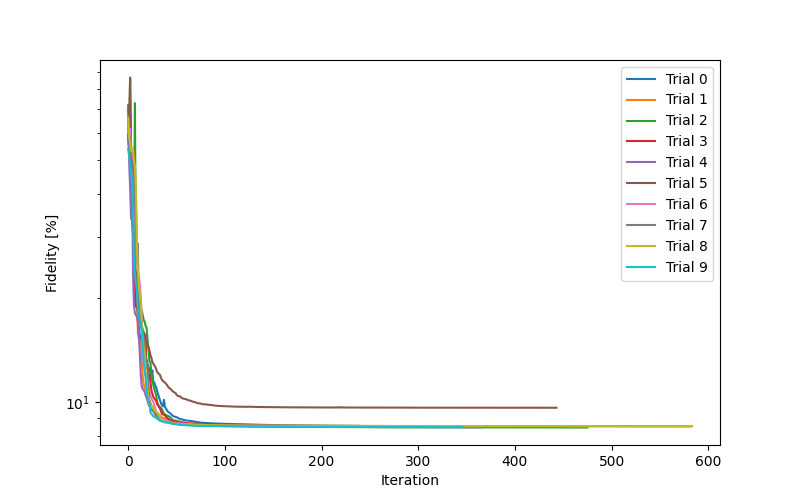

In [304]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

for i, opt_res in enumerate(optimization_result['cost_history']['iteration_values']):

    y = 1e2*np.array([opt_res]).flatten()
    ax.plot(y, label=f'Trial {i}')


ax.set_yscale('log')
ax.set_xlabel('Iteration')
ax.set_ylabel('Fidelity [%]')
ax.legend()

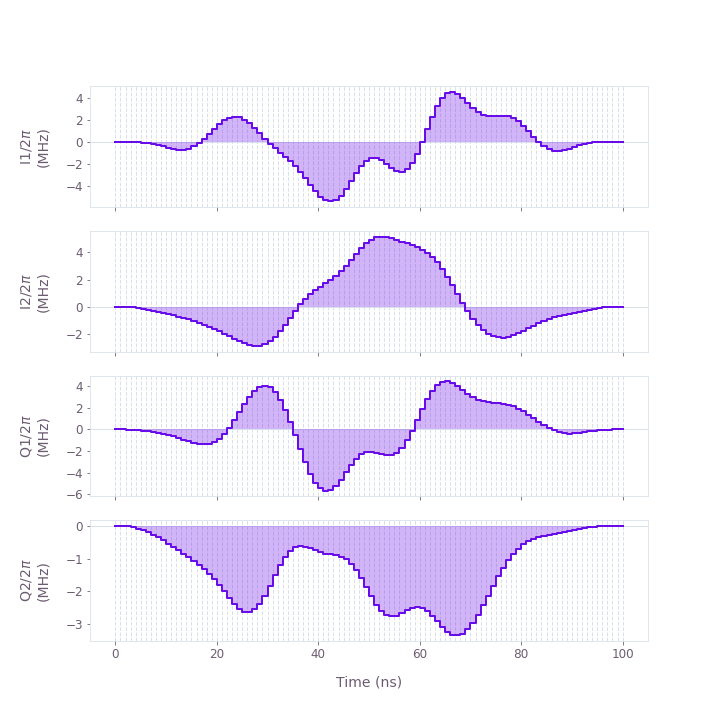

In [305]:
qctrlvisualizer.plot_controls(controls=optimization_result['output'], two_pi_factor=True, polar=False)

In [306]:
output = optimization_result['output']

In [307]:
time_steps = output['Q1']['durations']
time_vec = np.cumsum(time_steps)

# find the index where the time steps are the same

idx_same = np.where(time_steps < gate_duration/segment_count/10)[0]

In [308]:
drive_output_1 = output['I1']['values'] + 1j*output['Q1']['values']
drive_output_i1 = output['I1']['values']
drive_output_q1 = output['Q1']['values']

drive_output_2 = output['I2']['values'] + 1j*output['Q2']['values']
drive_output_i2 = output['I2']['values']
drive_output_q2 = output['Q2']['values']

# delete the time steps that are the same

drive_output_1 = np.delete(drive_output_1, idx_same)
drive_output_i1 = np.delete(drive_output_i1, idx_same)
drive_output_q1 = np.delete(drive_output_q1, idx_same)

drive_output_2 = np.delete(drive_output_2, idx_same)
drive_output_i2 = np.delete(drive_output_i2, idx_same)
drive_output_q2 = np.delete(drive_output_q2, idx_same)

    

In [309]:
drive_output_1.shape

(100,)

## Warm start 

In [313]:
# compute the unitaries for the optimized controls

graph_unitary = bo.Graph()

drive_opt1 = graph_unitary.hermitian_part(graph_unitary.pwc_operator(signal=graph_unitary.pwc_signal(values=drive_output_1.conj()*2*np.pi, duration=gate_duration), operator=qram.a_ops[0].data.todense()))
drive_opt2 = graph_unitary.hermitian_part(graph_unitary.pwc_operator(signal=graph_unitary.pwc_signal(values=drive_output_2.conj()*2*np.pi, duration=gate_duration), operator=qram.a_ops[1].data.todense()))

drive_opt = graph_unitary.pwc_sum([drive_opt1, drive_opt2])


H_drift_opt = graph_unitary.pwc_operator(
    signal=graph_unitary.pwc_signal(values=np.array([1]), duration=gate_duration),
    operator=H_zz_rot.data.todense(),
)


H_tot_opt = graph_unitary.pwc_sum([H_drift_opt, drive_opt])

sample_times = np.linspace(0, gate_duration, segment_count)

unitaries = graph_unitary.time_evolution_operators_pwc(
    hamiltonian=H_tot_opt, sample_times=sample_times, name="unitaries"
)

unitary_penalty = graph_unitary.time_evolution_operators_pwc(hamiltonian=H_tot_opt, sample_times=sample_times_penalty, name="unitary_penalty")



In [314]:
result = bo.execute_graph(graph=graph_unitary, output_node_names=["unitaries", "unitary_penalty"])

Your task (action_id="1997857") has started.
Your task (action_id="1997857") has completed.


In [315]:
result_penalty = result['output']['unitary_penalty']['value']


unitary_penalty_proj = U_penalty.conjugate().T @ result_penalty @ U_penalty

unitary_penalty_proj_abs = np.abs(unitary_penalty_proj)

unitary_penalty_proj_abs_sum = np.sum(unitary_penalty_proj_abs)/penalty_segments

unitary_penalty_proj_abs_sum*penalty_coeff


0.0

In [316]:
U_opt = qt.Qobj(result['output']['unitary_penalty']['value'][-1])
U_target = qt.Qobj(U_target)

if twoQ:
    U_target.dims = [[cutoffs[0], cutoffs[1]], [cutoffs[0], cutoffs[1]]]
    U_opt.dims = [[cutoffs[0], cutoffs[1]], [cutoffs[0], cutoffs[1]]]
else:
    U_target.dims = [[cutoffs[0], cutoffs[1], cutoffs[2], cutoffs[3]], [cutoffs[0], cutoffs[1], cutoffs[2], cutoffs[3]]]
    U_opt.dims = [[cutoffs[0], cutoffs[1], cutoffs[2], cutoffs[3]], [cutoffs[0], cutoffs[1], cutoffs[2], cutoffs[3]]]


# Infidelities = (1 - ((U_target.dag()*U_opt).tr()/(U_target.dag()*U_target).tr())**2).real
Infidelities = 1 - np.abs((U_target.dag()*U_opt).tr())/np.abs((U_target.dag()*U_target).tr())

print('Infidelity %.3f'%(Infidelities*100) + '%')

Infidelity 8.439%


In [317]:
U_target

Quantum object: dims = [[3, 3, 3, 3], [3, 3, 3, 3]], shape = (81, 81), type = oper, isherm = False
Qobj data =
[[0.70710678+0.j 0.        +0.j 0.        +0.j ... 0.        +0.j
  0.        +0.j 0.        +0.j]
 [0.        +0.j 0.70710678+0.j 0.        +0.j ... 0.        +0.j
  0.        +0.j 0.        +0.j]
 [0.        +0.j 0.        +0.j 0.        +0.j ... 0.        +0.j
  0.        +0.j 0.        +0.j]
 ...
 [0.        +0.j 0.        +0.j 0.        +0.j ... 0.        +0.j
  0.        +0.j 0.        +0.j]
 [0.        +0.j 0.        +0.j 0.        +0.j ... 0.        +0.j
  0.        +0.j 0.        +0.j]
 [0.        +0.j 0.        +0.j 0.        +0.j ... 0.        +0.j
  0.        +0.j 0.        +0.j]]

In [318]:
U_opt

Quantum object: dims = [[3, 3, 3, 3], [3, 3, 3, 3]], shape = (81, 81), type = oper, isherm = False
Qobj data =
[[ 7.17893630e-01+8.58734603e-02j -1.03884837e-15+1.21653146e-15j
   3.93634569e-17-1.35695709e-16j ... -7.33411562e-16+4.51746995e-17j
  -2.64068807e-16+2.58936000e-15j -8.42994407e-16+4.13879098e-15j]
 [ 7.03040950e-16+8.84074595e-16j  6.25499174e-01+3.16566939e-01j
   7.39097595e-17-3.24542270e-15j ...  1.28416109e-15+1.49213778e-16j
  -3.42126451e-15-2.96319160e-15j  2.00963477e-16-1.18184172e-15j]
 [-1.41704252e-17-3.20895269e-17j -1.39881170e-15-2.10770518e-15j
   1.25701019e-01+6.70927995e-01j ... -3.55633783e-16-9.68958496e-16j
   2.71350234e-16+3.83767380e-16j -1.36546338e-15+8.68290085e-16j]
 ...
 [-1.05571762e-15-1.42235463e-16j -1.73869540e-15-1.67888857e-16j
  -2.33126664e-16+1.11346299e-15j ... -8.80432623e-01-4.74166304e-01j
   2.34908755e-14+4.66477366e-14j -1.83791067e-15+3.00154326e-16j]
 [ 1.34223578e-15+2.35360671e-15j  3.00857650e-15-4.34149259e-15j
   2.4

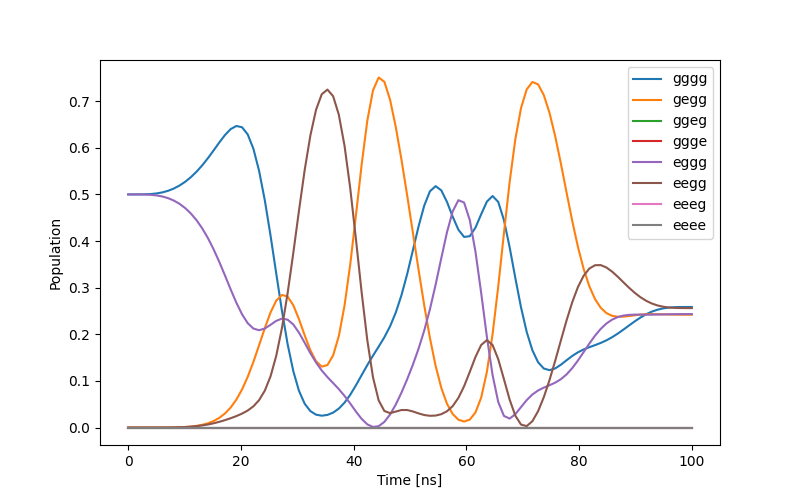

In [326]:
if twoQ:
    psi0 = (qram_zz_rot.state('gg') + qram_zz_rot.state('eg')).unit()
else:
    psi0 = (qram_zz_rot.state('eggg') + qram_zz_rot.state('gggg')).unit()

psi_ideal = U_target*psi0


psi_time = result['output']["unitaries"]["value"] @ (psi0.full())

# compute the overlap between the ideal and optimized states

overlap = [np.abs(psi_ideal.overlap(qt.Qobj(psi_time[t])))**2 for t in range(len(psi_time))]


if twoQ:

    gg = qram_zz_rot.state('gg')
    ge = qram_zz_rot.state('ge')
    eg = qram_zz_rot.state('eg')
    ee = qram_zz_rot.state('ee')

    # compute the populations of the states
    pop_gg = [np.abs(gg.overlap(qt.Qobj(psi_time[t])))**2 for t in range(len(psi_time))]
    pop_ge = [np.abs(ge.overlap(qt.Qobj(psi_time[t])))**2 for t in range(len(psi_time))]
    pop_eg = [np.abs(eg.overlap(qt.Qobj(psi_time[t])))**2 for t in range(len(psi_time))]
    pop_ee = [np.abs(ee.overlap(qt.Qobj(psi_time[t])))**2 for t in range(len(psi_time))]

    # plot the time evolution of the state
    fig, ax = plt.subplots(1, 1, figsize=(8, 5))
    ax.plot(sample_times*1e9, pop_gg, label='gg')
    ax.plot(sample_times*1e9, pop_ge, label='ge')
    ax.plot(sample_times*1e9, pop_eg, label='eg')
    ax.plot(sample_times*1e9, pop_ee, label='ee')

    # plot the sample time points for the penalty as vertical lines

    ax.set_xlabel('Time [ns]')
    ax.set_ylabel('Population')
    ax.legend()

else:

    gggg = qram_zz_rot.state('gggg')
    gegg = qram_zz_rot.state('gegg')
    ggeg = qram_zz_rot.state('ggeg')
    ggge = qram_zz_rot.state('ggge')
    eggg = qram_zz_rot.state('eggg')
    eegg = qram_zz_rot.state('eegg')
    eeeg = qram_zz_rot.state('eeeg')
    eeee = qram_zz_rot.state('eeee')

    # compute the populations of the states

    pop_gggg = [np.abs(gggg.overlap(qt.Qobj(psi_time[t])))**2 for t in range(len(psi_time))]
    pop_gegg = [np.abs(gegg.overlap(qt.Qobj(psi_time[t])))**2 for t in range(len(psi_time))]
    pop_ggeg = [np.abs(ggeg.overlap(qt.Qobj(psi_time[t])))**2 for t in range(len(psi_time))]
    pop_ggge = [np.abs(ggge.overlap(qt.Qobj(psi_time[t])))**2 for t in range(len(psi_time))]
    pop_eggg = [np.abs(eggg.overlap(qt.Qobj(psi_time[t])))**2 for t in range(len(psi_time))]
    pop_eegg = [np.abs(eegg.overlap(qt.Qobj(psi_time[t])))**2 for t in range(len(psi_time))]
    pop_eeeg = [np.abs(eeeg.overlap(qt.Qobj(psi_time[t])))**2 for t in range(len(psi_time))]
    pop_eeee = [np.abs(eeee.overlap(qt.Qobj(psi_time[t])))**2 for t in range(len(psi_time))]

    # plot the time evolution of the state
    fig, ax = plt.subplots(1, 1, figsize=(8, 5))
    ax.plot(sample_times*1e9, pop_gggg, label='gggg')
    ax.plot(sample_times*1e9, pop_gegg, label='gegg')
    ax.plot(sample_times*1e9, pop_ggeg, label='ggeg')
    ax.plot(sample_times*1e9, pop_ggge, label='ggge')
    ax.plot(sample_times*1e9, pop_eggg, label='eggg')
    ax.plot(sample_times*1e9, pop_eegg, label='eegg')
    ax.plot(sample_times*1e9, pop_eeeg, label='eeeg')
    ax.plot(sample_times*1e9, pop_eeee, label='eeee')

    ax.set_xlabel('Time [ns]')
    ax.set_ylabel('Population')
    ax.legend()

In [327]:
# project in the TLS subspace 

# partial trace on the final states to keep only the qubit subspace

if twoQ:

    U1 = np.zeros((cutoffs[0], cutoffs[0]))
    U2 = np.zeros((cutoffs[1], cutoffs[1]))
    U1[:2, :2] = qt.qeye(2).full()
    U2[:2, :2] = qt.qeye(2).full()
    U1 = qt.Qobj(U1)
    U2 = qt.Qobj(U2)
    U = qt.tensor(U1, U2).full()
    zeros = np.argwhere(np.diag(U) != 0).flatten()

else:

    U1 = np.zeros((cutoffs[0], cutoffs[0]))
    U2 = np.zeros((cutoffs[1], cutoffs[1]))
    U3 = np.zeros((cutoffs[2], cutoffs[2]))
    U4 = np.zeros((cutoffs[3], cutoffs[3]))

    U1[:2, :2] = qt.qeye(2).full()
    U2[:2, :2] = qt.qeye(2).full()
    U3[:2, :2] = qt.qeye(2).full()
    U4[:2, :2] = qt.qeye(2).full()

    U1 = qt.Qobj(U1)
    U2 = qt.Qobj(U2)
    U3 = qt.Qobj(U3)
    U4 = qt.Qobj(U4)

    U = qt.tensor(U1, U2, U3, U4).full()
    zeros = np.argwhere(np.diag(U) != 0).flatten()


 /var/folders/ly/kn2rqx_n00d94y4104blzhxm0000gn/T/ipykernel_35502/1882181246.py: 23ComplexWarning: Casting complex values to real discards the imaginary part
 /var/folders/ly/kn2rqx_n00d94y4104blzhxm0000gn/T/ipykernel_35502/1882181246.py: 24ComplexWarning: Casting complex values to real discards the imaginary part
 /var/folders/ly/kn2rqx_n00d94y4104blzhxm0000gn/T/ipykernel_35502/1882181246.py: 25ComplexWarning: Casting complex values to real discards the imaginary part
 /var/folders/ly/kn2rqx_n00d94y4104blzhxm0000gn/T/ipykernel_35502/1882181246.py: 26

In [328]:
# project the final state in the qubit subspace
psi_time_qb = psi_time[-1][zeros]
psi_time_qb = qt.Qobj(psi_time_qb)

if twoQ:
    psi_time_qb.dims = [[2, 2], [1, 1]]
else: 
    psi_time_qb.dims = [[2, 2, 2, 2], [1, 1, 1, 1]]


4


 /var/folders/ly/kn2rqx_n00d94y4104blzhxm0000gn/T/ipykernel_35502/3308495072.py: 20UserWarning: The figure layout has changed to tight
 /var/folders/ly/kn2rqx_n00d94y4104blzhxm0000gn/T/ipykernel_35502/3308495072.py: 47

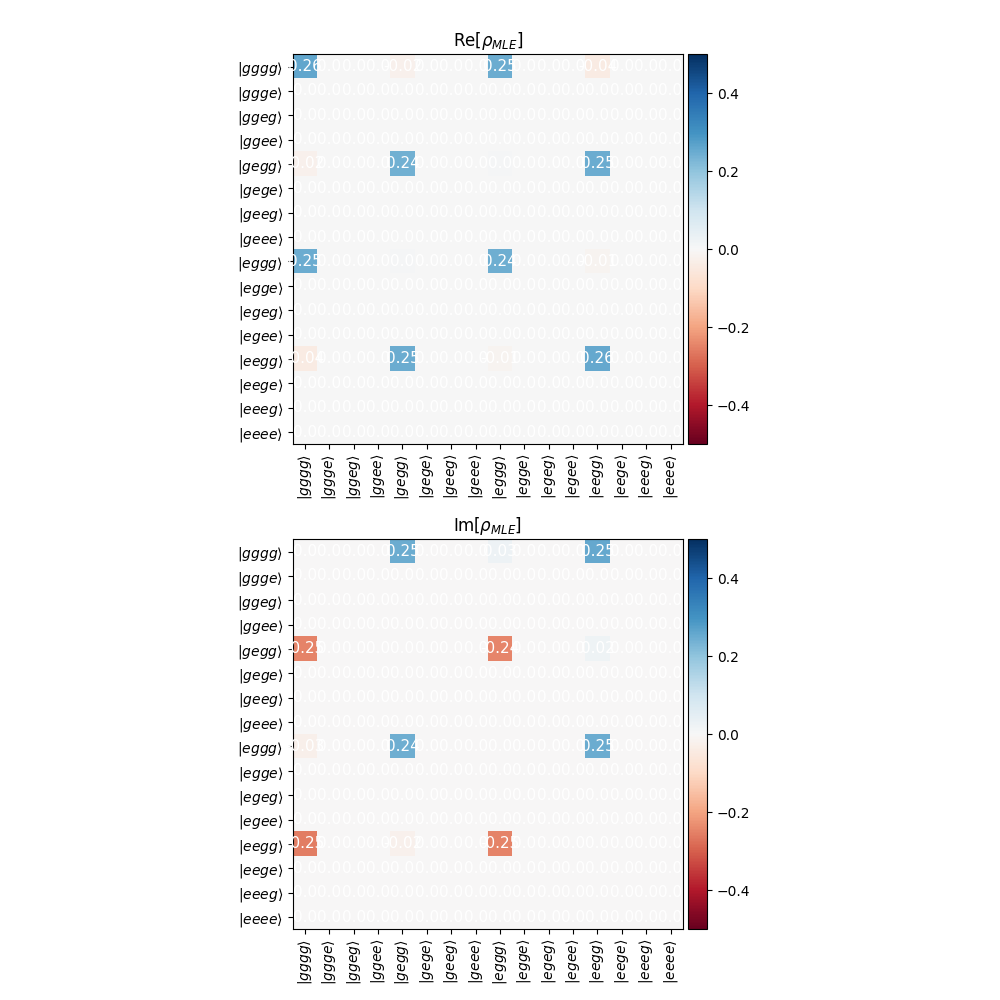

In [329]:
# plot the density matrix of the final state
rho_plot = psi_time_qb*psi_time_qb.dag()
show_plot_rho_2d(rho_plot, cmax=0.5, figsize=(10, 10))

In [331]:
seq = PulseSequence(start_time=0)
# seq_pi = PulseSequence(start_time=0)

nb_point_sim = 1000

time = np.linspace(0, gate_duration, segment_count)
if twoQ:
    seq.pulse_IQ(amp=1, wd=freq_dressed[0], I_values=drive_output_1.real, Q_values=drive_output_1.imag, pulse_levels=('gg','ge'),  times=time, drive_qubit=0, t_start=0, phase=0)
    seq.pulse_IQ(amp=1, wd=freq_dressed[1], I_values=drive_output_2.real, Q_values=drive_output_2.imag, pulse_levels=('gg','ge'),  times=time, drive_qubit=1, t_start=0, phase=0, t_offset=-gate_duration)
else:
    seq.pulse_IQ(amp=1, wd=freq_dressed[0], I_values=drive_output_1.real, Q_values=drive_output_1.imag, pulse_levels=('gggg','gegg'),  times=time, drive_qubit=0, t_start=0, phase=0)
    seq.pulse_IQ(amp=1, wd=freq_dressed[1], I_values=drive_output_2.real, Q_values=drive_output_2.imag, pulse_levels=('gggg','gegg'),  times=time, drive_qubit=1, t_start=0, phase=0, t_offset=-gate_duration)
times = np.linspace(0, seq.get_pulse_lengths()[-1], nb_point_sim)

[4144585866.376249, 3455665788.7229967] (GHz)
[1.e-07 1.e-07] (ns)
total pulse length 2.0000000000000002e-07 ns


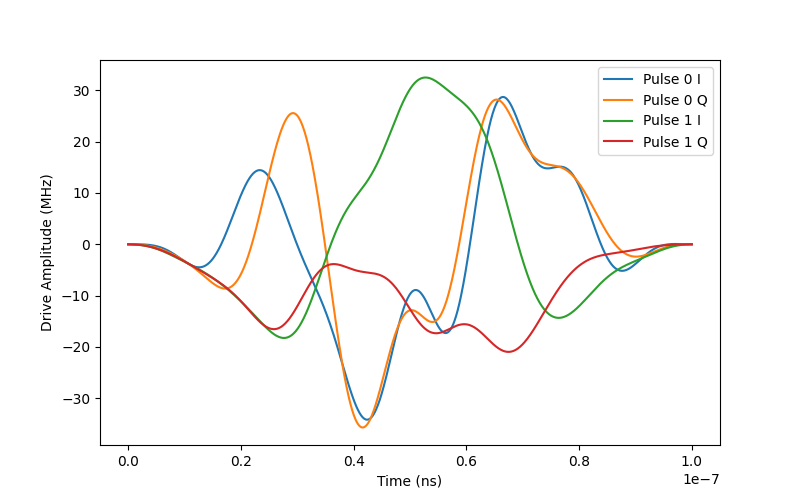

In [332]:
envelope_seq = seq.get_envelope_seq()
pulse_amps = seq.get_pulse_amps()
pulse_freqs = seq.get_pulse_freqs()
pulse_lens = seq.get_pulse_lengths()
drive_funcs = seq.get_pulse_seq()
print(seq.get_pulse_freqs(), '(GHz)')
print(pulse_lens, '(ns)')
print('total pulse length', sum(seq.get_pulse_lengths()), 'ns')


flat_times = np.array(times).flatten()
envelope_v_times = []






fig, ax = plt.subplots(1, 1, figsize=(8, 5))

for i in range(len(envelope_seq)):
    if isinstance(envelope_seq[i], list) and len(envelope_seq[i]) == 2:
        envelope_v_time_I = [pulse_amps[i]*envelope_seq[i][0](t)*1e-6 for t in flat_times]
        envelope_v_time_Q = [pulse_amps[i]*envelope_seq[i][1](t)*1e-6 for t in flat_times]
        ax.plot(flat_times, envelope_v_time_I, label=f'Pulse {i} I')
        ax.plot(flat_times, envelope_v_time_Q, label=f'Pulse {i} Q')
        # ax.plot(time, drive_output_i/1e6, label=f'Pulse {i} I opt')
        # ax.plot(time, drive_output_q/1e6, label=f'Pulse {i} Q opt')
    else:
        envelope_v_time = [pulse_amps[i]*envelope_seq[i](t)*1e3 for t in flat_times]
        envelope_v_times.append(envelope_v_time)
        plt.plot(flat_times, envelope_v_time, label=f'Pulse {i}')
ax.set_xlabel('Time (ns)')
ax.set_ylabel('Drive Amplitude (MHz)')
# plt.xlim(0, 100)
ax.legend()

In [333]:
if twoQ:
    psi0 = (qram.state('gg') + qram.state('eg')).unit()
else:
    psi0 = (qram.state('eggg') + qram.state('gggg')).unit()
result_lab = qram.evolve(psi0, seq, times, c_ops=None, nsteps=20000, use_str_solve=False)


10.0%. Run time:   0.44s. Est. time left: 00:00:00:03
20.0%. Run time:   1.05s. Est. time left: 00:00:00:04
30.0%. Run time:   1.75s. Est. time left: 00:00:00:04
40.0%. Run time:   2.44s. Est. time left: 00:00:00:03
50.0%. Run time:   3.16s. Est. time left: 00:00:00:03
60.0%. Run time:   3.85s. Est. time left: 00:00:00:02
70.0%. Run time:   4.57s. Est. time left: 00:00:00:01
80.0%. Run time:   5.24s. Est. time left: 00:00:00:01
90.0%. Run time:   5.94s. Est. time left: 00:00:00:00
Total run time:   6.55s


In [334]:
evals, evecs = qram.H_rot_unrolled().eigenstates()
result_rot = [0*result_lab[i_t] for i_t in range(len(times))]

# result_rot = result_lab

for i_t, t in enumerate(tqdm(times)):
    for eval, evec in zip(evals, evecs):
        result_rot[i_t] += np.exp(1j*eval*t) * evec.overlap(result_lab[i_t]) * evec

100%|██████████| 1000/1000 [00:08<00:00, 117.73it/s]


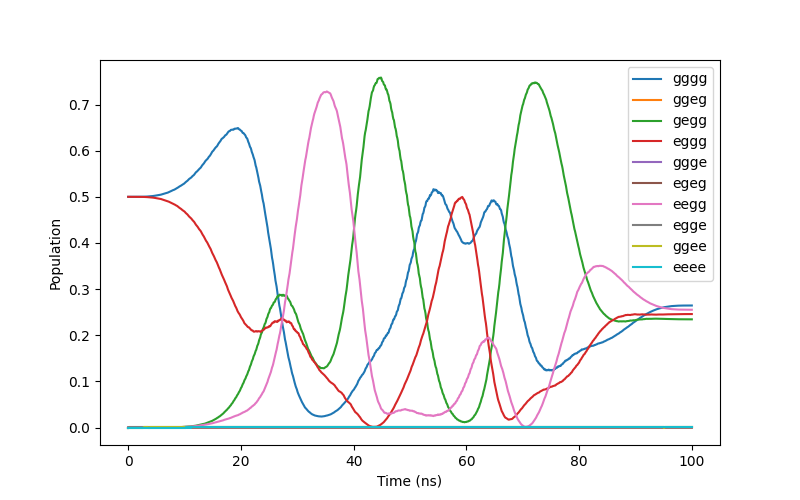

In [335]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

if twoQ:

    eg = qram.state('eg')
    gg = qram.state('gg')
    ee = qram.state('ee')
    ge = qram.state('ge')

    prob_eg = [np.abs(eg.overlap(result_rot[t]))**2 for t in range(len(times))]
    prob_gg = [np.abs(gg.overlap(result_rot[t]))**2 for t in range(len(times))]
    prob_ee = [np.abs(ee.overlap(result_rot[t]))**2 for t in range(len(times))]
    prob_ge = [np.abs(ge.overlap(result_rot[t]))**2 for t in range(len(times))]

    ax.plot(times*1e9, prob_eg, label='eg')
    ax.plot(times*1e9, prob_gg, label='gg')
    ax.plot(times*1e9, prob_ee, label='ee')
    ax.plot(times*1e9, prob_ge, label='ge')

    # add the unitary solution in dashed line 

    ax.plot(sample_times*1e9, pop_gg, label='gg', linestyle='dashed')
    ax.plot(sample_times*1e9, pop_ge, label='ge', linestyle='dashed')
    ax.plot(sample_times*1e9, pop_eg, label='eg', linestyle='dashed')
    ax.plot(sample_times*1e9, pop_ee, label='ee', linestyle='dashed')



else:

    gggg = qram.state('gggg')
    ggeg = qram.state('ggeg')
    gegg = qram.state('gegg')
    eggg = qram.state('eggg')
    ggge = qram.state('ggge')
    egeg = qram.state('egeg')
    eegg = qram.state('eegg')
    egge = qram.state('egge')
    ggee = qram.state('ggee')
    eeee = qram.state('eeee')

    prob_gggg = [np.abs(gggg.overlap(result_rot[t]))**2 for t in range(len(times))]
    prob_ggeg = [np.abs(ggeg.overlap(result_rot[t]))**2 for t in range(len(times))]
    prob_gegg = [np.abs(gegg.overlap(result_rot[t]))**2 for t in range(len(times))]
    prob_eggg = [np.abs(eggg.overlap(result_rot[t]))**2 for t in range(len(times))]
    prob_ggge = [np.abs(ggge.overlap(result_rot[t]))**2 for t in range(len(times))]
    prob_egeg = [np.abs(egeg.overlap(result_rot[t]))**2 for t in range(len(times))]
    prob_eegg = [np.abs(eegg.overlap(result_rot[t]))**2 for t in range(len(times))]
    prob_egge = [np.abs(egge.overlap(result_rot[t]))**2 for t in range(len(times))]
    prob_ggee = [np.abs(ggee.overlap(result_rot[t]))**2 for t in range(len(times))]
    prob_eeee = [np.abs(eeee.overlap(result_rot[t]))**2 for t in range(len(times))]



    ax.plot(times*1e9, prob_gggg, label='gggg')
    ax.plot(times*1e9, prob_ggeg, label='ggeg')
    ax.plot(times*1e9, prob_gegg, label='gegg')
    ax.plot(times*1e9, prob_eggg, label='eggg')
    ax.plot(times*1e9, prob_ggge, label='ggge')
    ax.plot(times*1e9, prob_egeg, label='egeg')
    ax.plot(times*1e9, prob_eegg, label='eegg')
    ax.plot(times*1e9, prob_egge, label='egge')
    ax.plot(times*1e9, prob_ggee, label='ggee')
    ax.plot(times*1e9, prob_eeee, label='eeee')




ax.set_xlabel('Time (ns)')
ax.set_ylabel('Population')
ax.legend()


4


 /var/folders/ly/kn2rqx_n00d94y4104blzhxm0000gn/T/ipykernel_35502/3308495072.py: 20UserWarning: The figure layout has changed to tight
 /var/folders/ly/kn2rqx_n00d94y4104blzhxm0000gn/T/ipykernel_35502/3308495072.py: 47

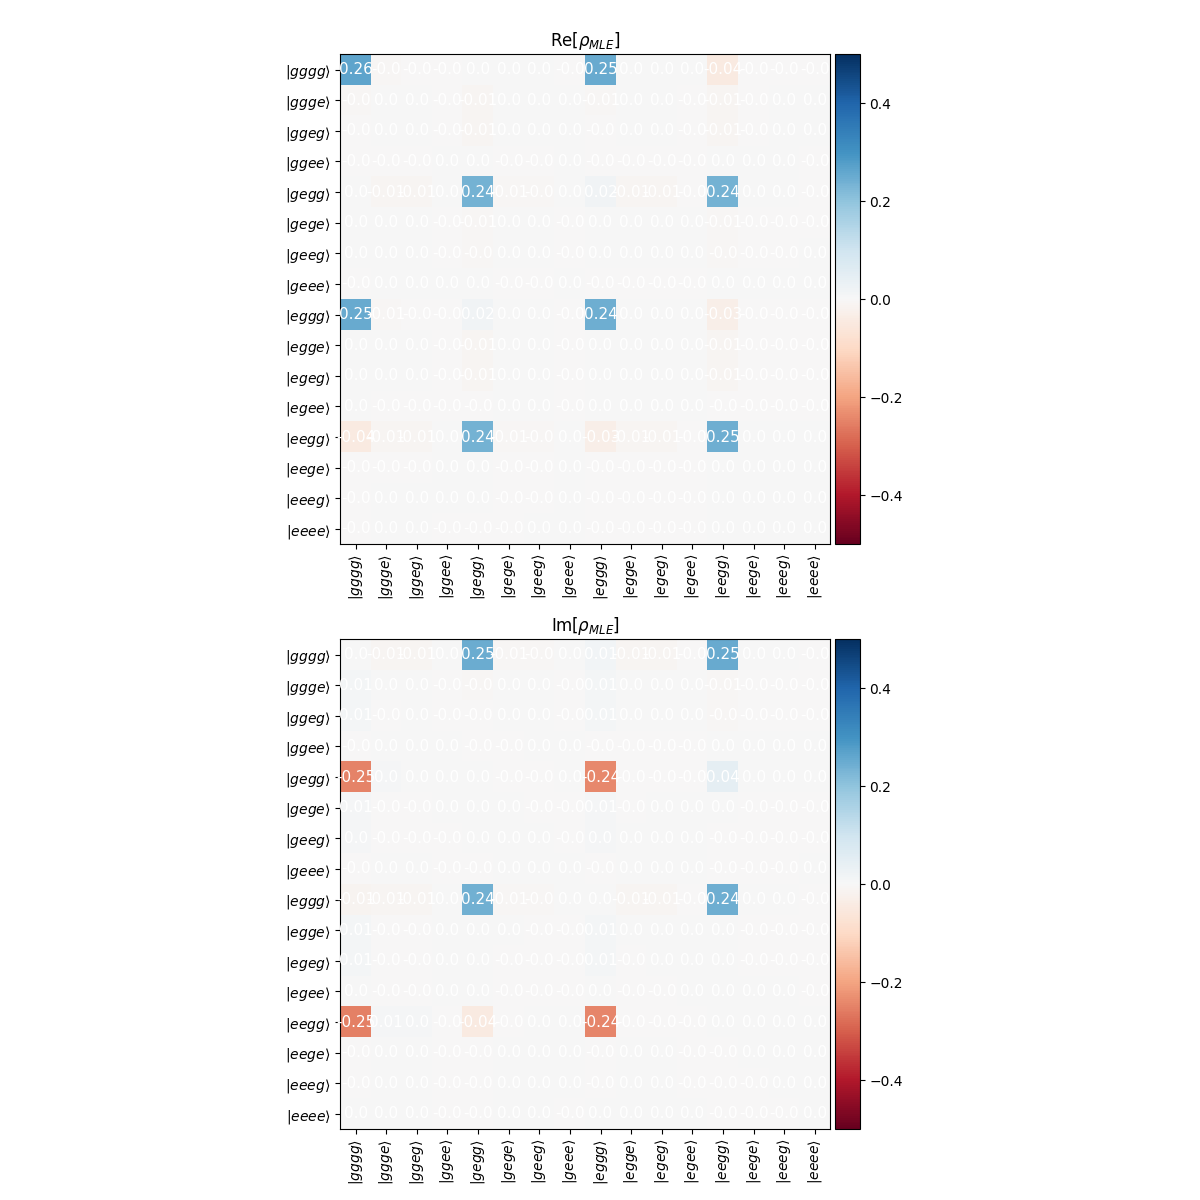

In [338]:
# project the final state in the qubit subspace
psi_plot = result_rot[-1].full()[zeros]
psi_plot = qt.Qobj(psi_plot)
if twoQ:
    psi_plot.dims = [[2, 2], [1, 1]]
else:
    psi_plot.dims = [[2, 2, 2, 2], [1, 1, 1, 1]]

# plot the density matrix of the final state

rho_plot = psi_plot*psi_plot.dag()

show_plot_rho_2d(rho_plot, cmax=0.5, figsize=(12, 12))

In [339]:
qram_zz = QSwitch(
    EJs=None,
    ECs=None,
    gs=None,
    qubit_freqs=freq_dressed/2/np.pi,
    alphas=self_kerr,
    cutoffs=cutoffs,
    isCavity=isCavity,
    useZZs=True,
    ZZs=ZZ_mat,
    crosstalk=None,
)



Crosstalk 0 0 1.0
Crosstalk 0 1 0.0
Crosstalk 0 2 0.0
Crosstalk 0 3 0.0
Crosstalk 1 1 1.0
Crosstalk 1 0 0.0
Crosstalk 1 2 0.0
Crosstalk 1 3 0.0
Crosstalk 2 2 1.0
Crosstalk 2 0 0.0
Crosstalk 2 1 0.0
Crosstalk 2 3 0.0
Crosstalk 3 3 1.0
Crosstalk 3 0 0.0
Crosstalk 3 1 0.0
Crosstalk 3 2 0.0


In [340]:
freq_dressed/1e9

array([26.04120102, 21.71258851, 30.17466259, 27.75277616])

In [343]:
result_disp =  qram_zz.evolve_rot_frame(psi0, seq, times, c_ops=None, nsteps=20000)

result_rot = result_disp

[4.14458587 3.45566579 0.         0.        ]
10.0%. Run time:   0.17s. Est. time left: 00:00:00:01
20.0%. Run time:   0.36s. Est. time left: 00:00:00:01
30.0%. Run time:   0.54s. Est. time left: 00:00:00:01
40.0%. Run time:   0.77s. Est. time left: 00:00:00:01
50.0%. Run time:   0.94s. Est. time left: 00:00:00:00
60.0%. Run time:   1.15s. Est. time left: 00:00:00:00
70.0%. Run time:   1.32s. Est. time left: 00:00:00:00
80.0%. Run time:   1.49s. Est. time left: 00:00:00:00
90.0%. Run time:   1.66s. Est. time left: 00:00:00:00
Total run time:   1.83s


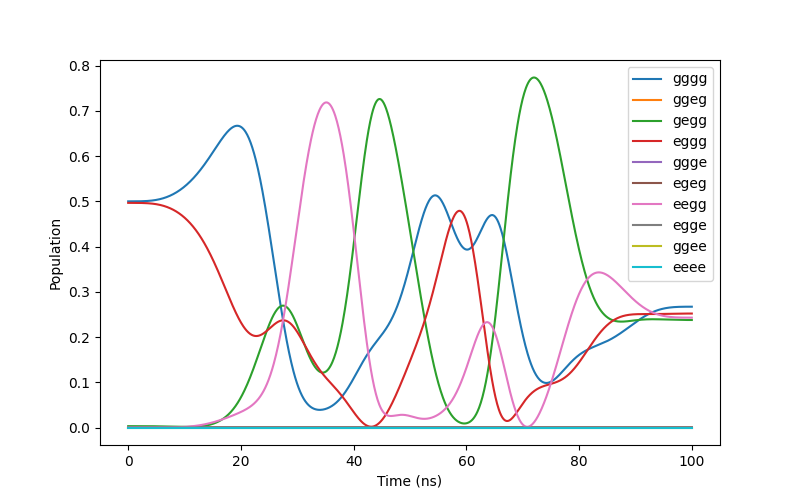

In [344]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

if twoQ:

    eg = qram_zz.state('eg')
    gg = qram_zz.state('gg')
    ee = qram_zz.state('ee')
    ge = qram_zz.state('ge')

    prob_eg = [np.abs(eg.overlap(result_rot[t]))**2 for t in range(len(times))]
    prob_gg = [np.abs(gg.overlap(result_rot[t]))**2 for t in range(len(times))]
    prob_ee = [np.abs(ee.overlap(result_rot[t]))**2 for t in range(len(times))]
    prob_ge = [np.abs(ge.overlap(result_rot[t]))**2 for t in range(len(times))]

    ax.plot(times*1e9, prob_eg, label='eg')
    ax.plot(times*1e9, prob_gg, label='gg')
    ax.plot(times*1e9, prob_ee, label='ee')
    ax.plot(times*1e9, prob_ge, label='ge')

    # add the unitary solution in dashed line 

    ax.plot(sample_times*1e9, pop_gg, label='gg', linestyle='dashed')
    ax.plot(sample_times*1e9, pop_ge, label='ge', linestyle='dashed')
    ax.plot(sample_times*1e9, pop_eg, label='eg', linestyle='dashed')
    ax.plot(sample_times*1e9, pop_ee, label='ee', linestyle='dashed')

else: 


    gggg = qram_zz.state('gggg')
    ggeg = qram_zz.state('ggeg')
    gegg = qram_zz.state('gegg')
    eggg = qram_zz.state('eggg')
    ggge = qram_zz.state('ggge')
    egeg = qram_zz.state('egeg')
    eegg = qram_zz.state('eegg')
    egge = qram_zz.state('egge')
    ggee = qram_zz.state('ggee')
    eeee = qram_zz.state('eeee')

    prob_gggg = [np.abs(gggg.overlap(result_rot[t]))**2 for t in range(len(times))]
    prob_ggeg = [np.abs(ggeg.overlap(result_rot[t]))**2 for t in range(len(times))]
    prob_gegg = [np.abs(gegg.overlap(result_rot[t]))**2 for t in range(len(times))]
    prob_eggg = [np.abs(eggg.overlap(result_rot[t]))**2 for t in range(len(times))]
    prob_ggge = [np.abs(ggge.overlap(result_rot[t]))**2 for t in range(len(times))]
    prob_egeg = [np.abs(egeg.overlap(result_rot[t]))**2 for t in range(len(times))]
    prob_eegg = [np.abs(eegg.overlap(result_rot[t]))**2 for t in range(len(times))]
    prob_egge = [np.abs(egge.overlap(result_rot[t]))**2 for t in range(len(times))]
    prob_ggee = [np.abs(ggee.overlap(result_rot[t]))**2 for t in range(len(times))]
    prob_eeee = [np.abs(eeee.overlap(result_rot[t]))**2 for t in range(len(times))]



    ax.plot(times*1e9, prob_gggg, label='gggg')
    ax.plot(times*1e9, prob_ggeg, label='ggeg')
    ax.plot(times*1e9, prob_gegg, label='gegg')
    ax.plot(times*1e9, prob_eggg, label='eggg')
    ax.plot(times*1e9, prob_ggge, label='ggge')
    ax.plot(times*1e9, prob_egeg, label='egeg')
    ax.plot(times*1e9, prob_eegg, label='eegg')
    ax.plot(times*1e9, prob_egge, label='egge')
    ax.plot(times*1e9, prob_ggee, label='ggee')
    ax.plot(times*1e9, prob_eeee, label='eeee')




ax.set_xlabel('Time (ns)')
ax.set_ylabel('Population')
ax.legend()

    


4


 /var/folders/ly/kn2rqx_n00d94y4104blzhxm0000gn/T/ipykernel_35502/3308495072.py: 20UserWarning: The figure layout has changed to tight
 /var/folders/ly/kn2rqx_n00d94y4104blzhxm0000gn/T/ipykernel_35502/3308495072.py: 47

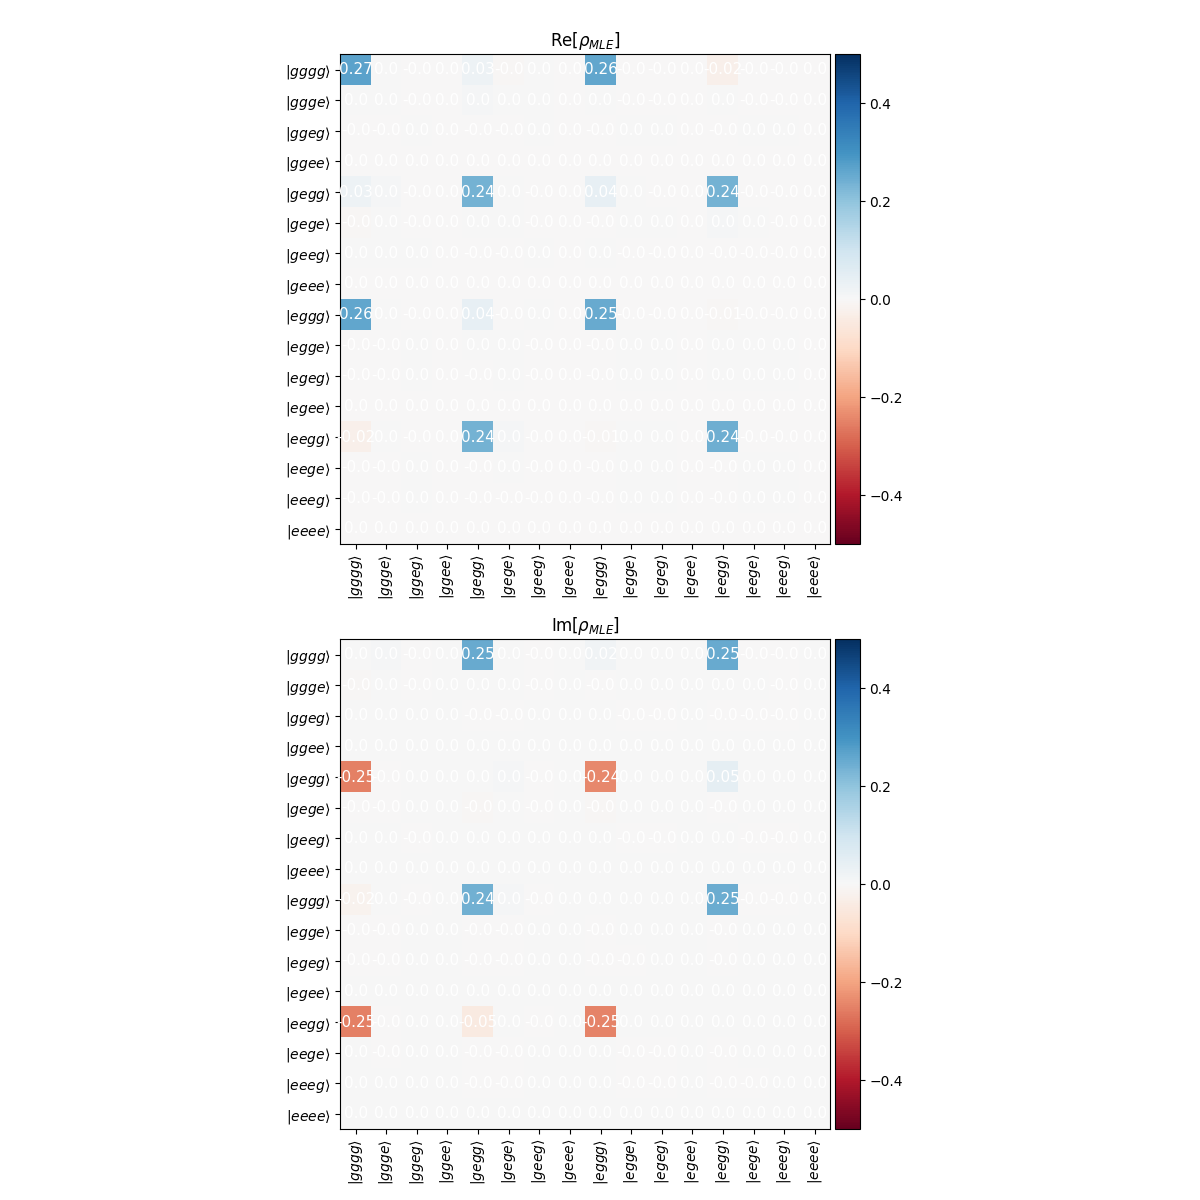

In [346]:
psi_plot = result_rot[-1].full()[zeros]
psi_plot = qt.Qobj(psi_plot)
if twoQ:
    psi_plot.dims = [[2, 2], [1, 1]]
else:
    psi_plot.dims = [[2, 2, 2, 2], [1, 1, 1, 1]]

# plot the density matrix of the final state

rho_plot = psi_plot*psi_plot.dag()

show_plot_rho_2d(rho_plot, cmax=0.5, figsize=(12, 12))